# CPU performance measuring and estimation

## Report by Thomas Wright

In this project my goal is to be able to look at a CPU and be able to tell what factors make that CPU fast. We can do this by looking at all the things that can affect a CPU speed graph and analyze them to come up with some rules and guidelines that can help us choose a CPU that performs well.

First thing we can do is start to gather and look at what these attributes are.

# Building graphs and models

First we import our utility scripts and libraries

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib as mp
import seaborn as sns
import matplotlib.pyplot as plt

project_dir = '/home/atoris/course-project-thomas-wright/src'
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)


In [2]:
import datautil as du

In [3]:
url = 'https://www.cpubenchmark.net/mid_range_cpus.html'
filename = 'cpu_data_encoded.csv'

df = du.load_data(url, filename)


Now we can start to graph our data

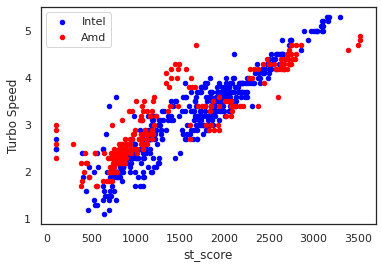

In [15]:
amd = df[df['brand_Amd'] == 1]
intel = df[df['brand_Intel'] == 1]

def graph(x, y):
    ax = intel.plot(y=y, x=x, kind='scatter', label="Intel", color="Blue")
    amd.plot(y=y, x=x, kind='scatter', label="Amd", ax=ax, color="red")
    
graph('st_score', 'Turbo Speed')

We can see a basic trend of a higher clock speed allowing for better single threaded performace, here are a few more graphs that I though had interesting results.

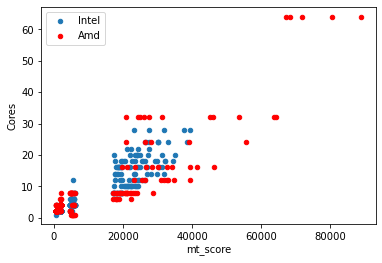

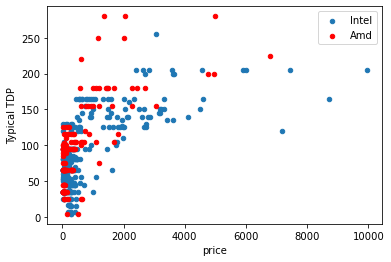

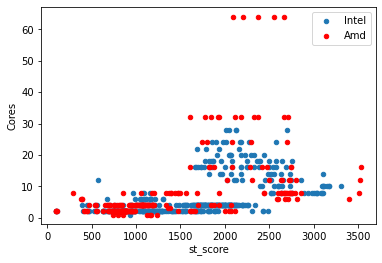

In [5]:

graph('mt_score', 'Cores')
graph('price', 'Typical TDP')
graph('st_score', 'Cores')

# CPU attribute graph builder

We can look at any attribute againts another attribute, here you can choose what you want to compare and build a graph to visualize the comparision.

In [14]:
import ipywidgets as widgets

columns = ['price', 'Clockspeed', 'Turbo Speed', 'Threads', 'Cores', 'Typical TDP', 'mt_score', 'st_score']

def graph_update(x, y, ax):
        intel.plot(y=y, x=x, kind='scatter', label="Intel", ax=ax, color="Blue")
        amd.plot(y=y, x=x, kind='scatter', label="Amd", ax=ax, color='Red')
        



im = widgets.interact_manual(

    X_axis=columns, Y_axis=columns,)
def plot(X_axis='Cores', Y_axis='Turbo Speed', grid=True):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    graph_update(X_axis, Y_axis, ax)

    ax.grid(grid)
    
im = im(plot)
im.widget.children[3].description = "Create Graph"



interactive(children=(Dropdown(description='X_axis', index=4, options=('price', 'Clockspeed', 'Turbo Speed', '…

# Creating the model

Next we can split up our data and feed it into a Classifier.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
import seaborn as sns
np.random.seed(10)
sns.set_theme()
df.dropna(subset=['Typical TDP'], inplace=True)


features = df.drop(['mt_score', 'name', 'Socket', 'st_score', 'price'], axis=1)
target = df['mt_score'].tolist()

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.25)


clf = RandomForestClassifier(n_estimators=250,max_features=9)
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)



Finally we can use our model to make some assumptions. Here we can look at how each factor contributes to the multithreaded performance of a cpu.

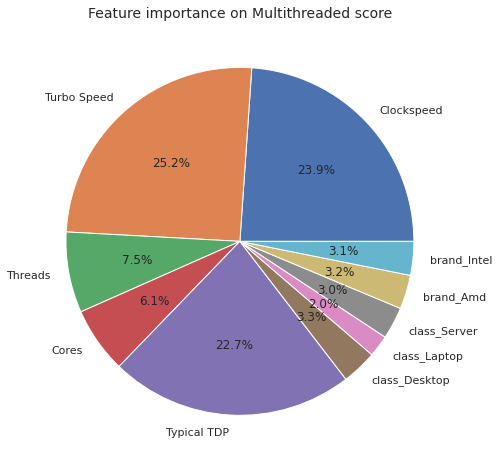

In [8]:

labels = pd.Index(['Clockspeed', 'Turbo Speed', 'Threads', 'Cores', 'Typical TDP', 'class_Desktop', 'class_Laptop', 'class_Server', 'brand_Amd', 'brand_Intel'])
importance = pd.Series(data=clf.feature_importances_, index=labels)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.set_style("white")


plt.pie(x=importance, labels=labels, autopct="%.1f%%")
plt.title("Feature importance on Multithreaded score", fontsize=14);
fig.savefig('../data/Feature_importance.png')

# Using a model for predictions

Finally we can create our own hypotheical CPU and see how well it would perform in a multithreaded application

In [9]:
im = widgets.interact_manual(

    clock_speed=widgets.IntSlider(min=1000, max=6000, step=1, value=3800),
    turbo_speed=widgets.IntSlider(min=1000, max=6000, step=1, value=3800),
    cores=widgets.IntSlider(min=1, max=64, step=1, value=4),
    threads=widgets.IntSlider(min=1, max=128, step=1, value=8),
    tdp=widgets.IntSlider(min=10, max=300, step=1, value=95),
    cpu_class = widgets.RadioButtons(
            options=['desktop', 'server', 'laptop'],
            description='Platform:',
            disabled=False),
    brand = widgets.RadioButtons(
            options=['intel', 'amd'],
            description='Brand:',
            disabled=False)

        )
def predict(clock_speed=3800, turbo_speed=4100, cores=4, threads=8, tdp=95, cpu_class='desktop', brand='intel'):
    data = {'Clockspeed' : [clock_speed/1000],
            'Turbo Speed' : [turbo_speed/1000],
            'Threads' : [threads],
            'Cores' : [cores],
            'Typical TDP' : [tdp],
            'class_Desktop' : [0],
            'class_Server' : [0],
            'class_Laptop' : [0],
            'brand_Amd' : [0],
            'brand_Intel' : [0]}
    if(cpu_class == 'desktop'):
        data['class_Desktop'] = 1
    if(cpu_class == 'server'):
        data['class_Server'] = 1
    if(cpu_class == 'laptop'):
        data['class_Laptop'] = 1
    if(brand == 'intel'):
        data['brand_Intel'] = 1
    if(brand == 'amd'):
        data['brand_Amd'] = 1

    
    df_data = pd.DataFrame(data)
    result = clf.predict(df_data)
    print("\nThis cpu configuration would have an estimate of a " + str(result) + " Multithreaded score.\n")

    
    
    
im = im(predict)
im.widget.children[0].description = "Clock Speed (Mhz)"
im.widget.children[1].description = "Turbo Speed (Mhz)"
im.widget.children[2].description = "Core Count"
im.widget.children[3].description = "Thread Count"
im.widget.children[4].description = "TDP"
im.widget.children[7].description = "Generate"




interactive(children=(IntSlider(value=3800, description='clock_speed', max=6000, min=1000), IntSlider(value=38…

# Building a better model

The results from that don't seem very accurate to the inputs so pruning our less important feature may help us get a better prediction.

Also we can switch to a linear regression classification as it would suit the data better now that we know what features to exclude.

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression


features = df.drop(['mt_score', 'name', 'Socket', 'st_score', 'price', 'class_Laptop', 'class_Desktop', 'class_Server', 'brand_Amd', 'brand_Intel'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.25)


clf2 = LinearRegression()
clf2.fit(X_train, y_train)

im2 = widgets.interact_manual(

    clock_speed=widgets.IntSlider(min=1000, max=6000, step=1, value=3800),
    turbo_speed=widgets.IntSlider(min=1000, max=6000, step=1, value=3800),
    cores=widgets.IntSlider(min=1, max=64, step=1, value=4),
    threads=widgets.IntSlider(min=1, max=128, step=1, value=8),
    tdp=widgets.IntSlider(min=10, max=300, step=1, value=95)
)

def predict(clock_speed=3800, turbo_speed=4100, cores=4, threads=8, tdp=95):
    data = {'Clockspeed' : [clock_speed/1000],
            'Turbo Speed' : [turbo_speed/1000],
            'Threads' : [threads],
            'Cores' : [cores],
            'Typical TDP' : [tdp]}
    df_data = pd.DataFrame(data)
    result = clf2.predict(df_data)
    print("\nThis cpu configuration would have an estimate of a " + str(result) + " Multithreaded score.\n")


im2 = im2(predict)
im2.widget.children[0].description = "Clock Speed (Mhz)"
im2.widget.children[1].description = "Turbo Speed (Mhz)"
im2.widget.children[2].description = "Core Count"
im2.widget.children[3].description = "Thread Count"
im2.widget.children[4].description = "TDP"
im2.widget.children[5].description = "Generate"




interactive(children=(IntSlider(value=3800, description='clock_speed', max=6000, min=1000), IntSlider(value=38…

# Final Thoughts

I think this project came out rather well given the amount of data that was availabe to the model. There are few issues with the model one being it see's core count as a negative attribute but overall I am pleased with the final performance of the cpu multihreaded score estimation tool.

The data I used was from www.cpubenchmark.net, and is still avaialable there but if you want to use the data that I cleaned or gathered without pinging their server hundreds of times it's availabe at the projects github https://github.com/cpsc6300/course-project-thomas-wright.